# Theory

### Decision Tree  
 IN DT, I measure variation/Impurity using: 
 - DT Classifier -> 
     - Std. deviation 
 - DT Regression -> 
     - (Mostly used) Gini index -> Gini =   Summation(i) (P(i)* (1-P(i) ) 
     - (Not useld oftenly) Entropy -> E = Summation(i) (-P(i)*Log(P(i))) 
 
### Naive Bayes 
Naive bayes assumes that features are independant of eachother. Meaning that P(x1)=P(x1|x2).  
It also assumes that data is normally distributed for continous data. 

1. P(y|x) = P(y∩x)/P(x)
   P(x|y) = P(x∩y)/P(y)
2. P(y|x) = P(x|y)*P(y) / P(x)
   P(x|y) = P(y|x)*P(x) / P(y)
   

In [261]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

from warnings import filterwarnings 
filterwarnings("ignore") 


# Data Preprocessing
### 1- Understand the data


In [262]:
df = pd.read_csv("Titanic_DS.csv")

In [263]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [264]:
cols_to_drop = 'PassengerId Name Ticket'.split() 

In [265]:
df.drop(cols_to_drop , axis = 1 , inplace=True)

### 2-Dtypes
***Check Dtypes***

In [266]:
dtypes = df.dtypes
n_unique = df.nunique()
pd.DataFrame({ "Dtypes":dtypes , "N_unique":n_unique}).T

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
Dtypes,int64,int64,object,float64,int64,int64,float64,object,object
N_unique,2,3,2,88,7,7,248,147,3


For int's with discrete values, I deal with them as categorical features 

Therefor Survuved/Pclass/SibSp/Parch/Embarked are catogorcal 

***Modify Dtypes***

In [267]:
cat_cols = 'Survived Pclass Sex SibSp Parch Cabin Embarked'.split()

In [268]:
df[cat_cols] = df[cat_cols].astype("category")

***Check Dtypes after modidfcation***

In [269]:
dtypes = df.dtypes
n_unique = df.nunique()
pd.DataFrame({ "Dtypes":dtypes , "N_unique":n_unique}).T

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
Dtypes,category,category,category,float64,category,category,float64,category,category
N_unique,2,3,2,88,7,7,248,147,3


***Rearrange cols***

In [270]:
cols = df.columns.tolist()
cols.pop(0)
cols.append("Survived")
df = df[cols]
df.head(1)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,3,male,22.0,1,0,7.25,NaN,S,0


### 3-Null Values

In [271]:
null = df.isnull().sum()
null_ratio = null/df.shape[0]
pd.DataFrame({"Null" : null , "Null_Ratio":null_ratio}).T

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
Null,0.0,0.0,177.000000,0.0,0.0,0.0,687.000000,2.000000,0.0
Null_Ratio,0.0,0.0,0.198653,0.0,0.0,0.0,0.771044,0.002245,0.0


- ***Drop Cabin column***
    - Because it contains high value of null 

In [272]:
df.drop(['Cabin'] , axis = 1 , inplace = True )

- ***Drop Null values in Embarked***
    - Because it contains little number of Nulls

In [273]:
df.dropna(subset=["Embarked"] , inplace = True)

- ***Replace null values in Age with mean***
    - Because it contains relatively high-ish number of Nulls

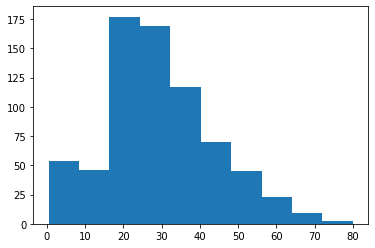

In [274]:
plt.hist(df['Age'])
plt.show()

Distrbution is skewed so Ill use the median to replace ^ 

In [275]:
df['Age'].fillna((df.Age.median()) ,inplace = True)

##### Confrim I removed all Null's

In [276]:
null = df.isnull().sum()
null_ratio = null/df.shape[0]
pd.DataFrame({"Null" : null , "Null_Ratio":null_ratio}).T

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
Null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Null_Ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4- Check for outliers 

- ***Check for outliers***

In [277]:
num_cols = df.select_dtypes("number").columns
num_cols

Index(['Age', 'Fare'], dtype='object')

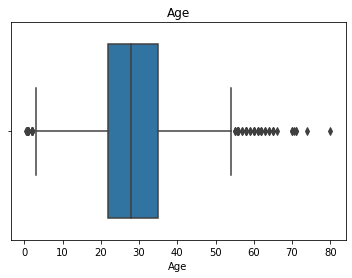

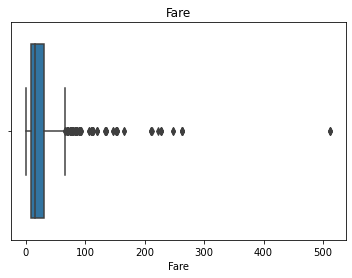

In [278]:
for col in num_cols:
    plt.title(col)
    sns.boxplot(df[col])
    plt.show()

I can also choose the upper by common sense and not the IQR's outliers, for example: by observation, I can pick "300" as the upper outlier for "fare" column^

- ***Replace outliers***

<AxesSubplot:xlabel='Age'>

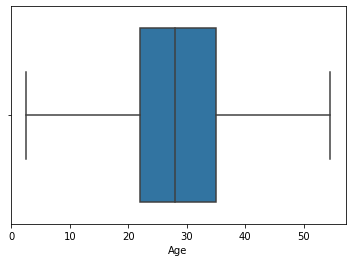

In [279]:
Q1 = df['Age'].quantile(.25)
Q3 = df['Age'].quantile(.75)
IQR = Q3 - Q1 
Upper = Q3 +1.5*IQR
Lower = Q1 -1.5*IQR

Upper_outliers = df [df['Age']>Upper]["Age"].values 
Lower_outliers = df [df['Age']<Lower]["Age"].values 

df["Age"].replace(Upper_outliers , Upper , inplace = True)
df["Age"].replace(Lower_outliers, Lower , inplace = True)

sns.boxplot(df.Age) #confirm I removed outliers

In [280]:
for col in num_cols :
    Q1 = df[col].quantile(.25)
    Q3 = df[col].quantile(.75)
    IQR = Q3 - Q1 
    
    Upper = Q3 + 1.5 * IQR
    Lower = Q1 - 1.5 * IQR
    
    Upper_outliers = df[df[col] > Upper ][col].values
    Lower_outliers = df[df[col] < Lower ][col].values
    
    
    df[col].replace(Upper_outliers , Upper , inplace= True)
    df[col].replace(Lower_outliers , Lower , inplace= True)

<AxesSubplot:xlabel='Fare'>

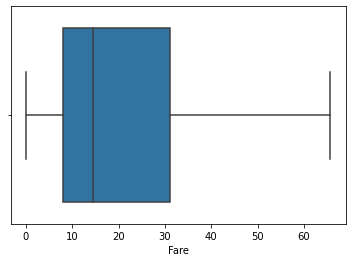

In [281]:
sns.boxplot(df.Fare)  #confirm I removed outliers

- ***Optional (Remove outliers) -> this approach isnt recommended most of the times as it creates new outliers and causes data loss*** 

In [282]:
#Q1 = df['Age'].quantile(.25)
#Q3 = df['Age'].quantile(.75)

#IQR = Q3 - Q1 

#Upper = Q3 +1.5*IQR
#Lower = Q1 -1.5*IQR

#############outliers = (df['Age']>Upper) | (df['Age']<Lower)
#rows_to_drop = df[(df['Age']>Upper) | (df['Age']<Lower)].index
#df.drop(rows_to_drop , axis = 0 ,  inplace = True)

### 5-Visualization

##### 5.1- Check for variation

- ***Numerical columns***

In [283]:
num_cols = df.select_dtypes("number").columns

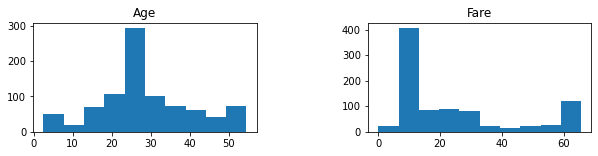

In [284]:
plt.figure(figsize=(10,2))
for i, col in enumerate(num_cols):
    plt.subplot(1,2,i+1)
    plt.title(col)
    plt.hist(df[col])
plt.subplots_adjust(hspace = .5 , wspace = 0.5)
plt.show()


- ***Categorical columns***

In [285]:
cat_cols = df.select_dtypes("category").columns

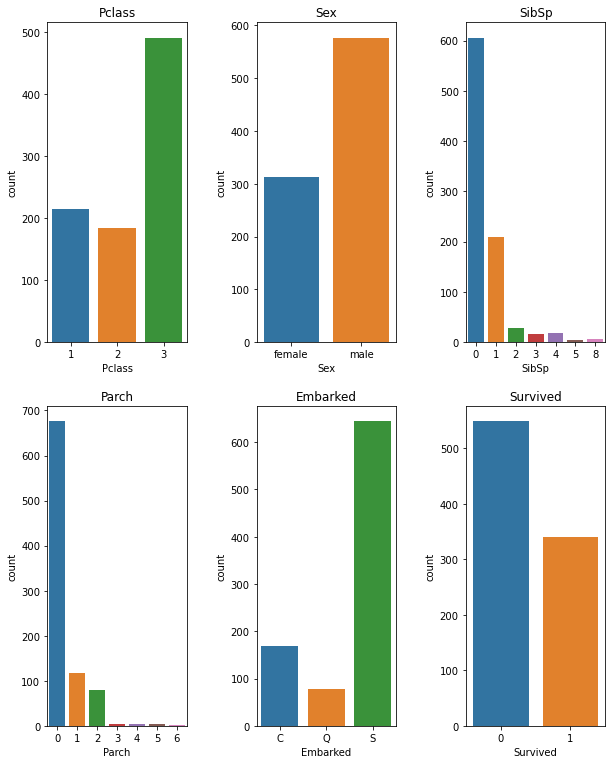

In [286]:
plt.figure(figsize=(10,20))
for i, col in enumerate(cat_cols):
    plt.subplot(3,3,i+1)
    plt.title(col)
    sns.countplot(x=col  , data = df)
plt.subplots_adjust(hspace = .2 , wspace = 0.5)
plt.show()


Parch and SibSp have very low variation, we can either drop them now or go ahead and build the model and run it. If the results were bad then I can bgo back and drop low variation features

Drop Parch as it has very low variation

In [287]:
df.drop(["Parch"] , axis = 1 , inplace = True)

##### 5.1- Check for relation between features and target

- 5.1.1-***Numerical Features***

In [288]:
num_cols = df.select_dtypes("number").columns
num_cols

Index(['Age', 'Fare'], dtype='object')

    - Plotting between categorical and numerical is using a barplot 

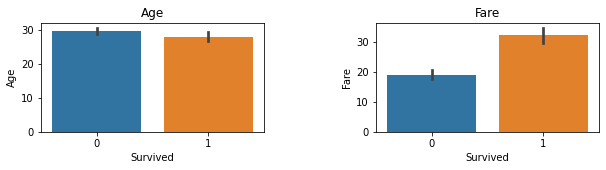

In [289]:
plt.figure(figsize=(10,2))
for i, col in enumerate(num_cols):
    plt.subplot(1,2,i+1)
    plt.title(col)
    sns.barplot(x = "Survived" , y = col , data = df )
plt.subplots_adjust(hspace = .5 , wspace = 0.5)
plt.show()

In [290]:
df.drop(["Age"] , axis = 1 , inplace = True)

Conclusion
- Age didnt afffect survival so we dropped it 
- Fair affected survival, the higher the fair the higher the survival rate and vice versa 
--------------------------------------------------------------------------------------------------------------

- 5.1.2-***Categorical Features***

In [291]:
agg = df.pivot_table(index = "Survived" , columns = "Pclass" , aggfunc = len)["Fare"]
agg

Pclass,1,2,3
Survived,,,
0,80.0,97.0,372.0
1,134.0,87.0,119.0


In [292]:
unique_vals = agg.columns.tolist()
dead = agg.iloc[0].tolist()
surv = agg.iloc[1].tolist()


<AxesSubplot:>

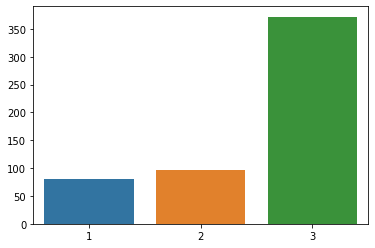

In [293]:
sns.barplot(x=unique_vals , y = dead )

<AxesSubplot:>

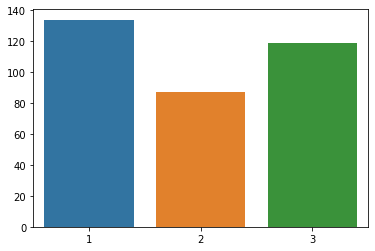

In [294]:
sns.barplot(x=unique_vals , y = surv )

Aggregation: 
   - If I create a pivot table based using agg. func, as mean/mode, columns for each feature will be added to the pivot table 
   - If I create a pivot table based using agg. func, as length (which is the count), only one columns of the other features will be added

Pclass,1,2,3
Survived,,,
0,80.0,97.0,372.0
1,134.0,87.0,119.0


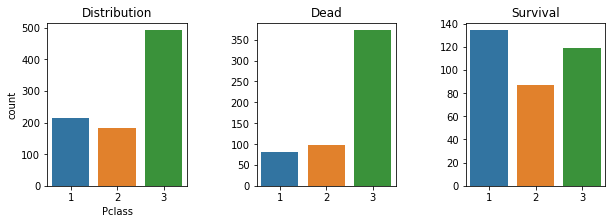

Sex,female,male
Survived,,
0,81.0,468.0
1,231.0,109.0


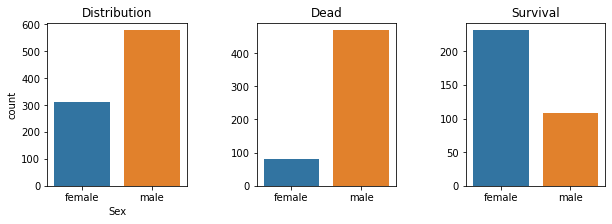

SibSp,0,1,2,3,4,5,8
Survived,,,,,,,
0,398.0,97.0,15.0,12.0,15.0,5.0,7.0
1,208.0,112.0,13.0,4.0,3.0,NaN,NaN


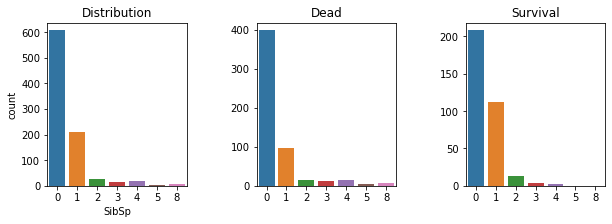

KeyError: 'Parch'

In [295]:
for col in cat_cols[:]:
    agg = df.pivot_table(index="Survived", columns=col, aggfunc=len)["Fare"]
    display(agg)

    uniq_vals = agg.columns.tolist()
    dead = agg.iloc[0].tolist()
    surv = agg.iloc[1].tolist()

    plt.figure(figsize=(10, 3))

    plt.subplot(1, 3, 1)
    plt.title("Distribution")
    sns.countplot(x=col, data=df)

    plt.subplot(1, 3, 2)
    plt.title("Dead")
    sns.barplot(x=uniq_vals, y=dead)

    plt.subplot(1, 3, 3)
    plt.title("Survival")
    sns.barplot(x=uniq_vals, y=surv)

    plt.subplots_adjust(wspace=.5)
    plt.show()
    print("=============================")

In [296]:
cat_cols

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Survived'], dtype='object')

<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

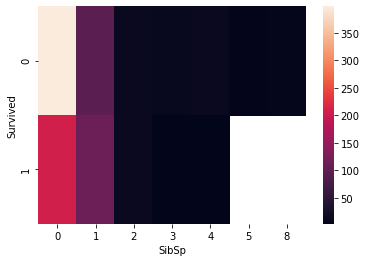

In [170]:
sns.heatmap(agg)

### 6- Duplicates

In [172]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

475


In [173]:
print(df.duplicated().sum())

0


### 7- Data Split

In [174]:
X = df.iloc[: , :-1]
y = df.iloc[: , -1:]

In [175]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, shuffle=True, random_state=42)

### 8- Normalization

In [176]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
num_cols = X_train.select_dtypes("number").columns 
scaler.fit(X_train[num_cols])

X_train[num_cols] = scaler.transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

### 7- Encoding

In [177]:
d_types = X.dtypes
n_unique= X.nunique()
pd.DataFrame({"Dtypes": d_types , "Nunqie" : n_unique}).T

,Pclass,Sex,SibSp,Fare,Embarked
Dtypes,category,category,category,float64,category
Nunqie,3,2,7,204,3


- **Oridinal Encoding** for order based features meaning that the order affects the meaning like S / M / L / XL in clothing. 

In [179]:
from category_encoders import OrdinalEncoder
ordinal_encoder = OrdinalEncoder(cols=["Sex" , "Embarked"])
ordinal_encoder.fit(X_train)

X_train = ordinal_encoder.transform(X_train)
X_val = ordinal_encoder.transform(X_val)
X_test = ordinal_encoder.transform(X_test)

- **OneHot Encoding** for nominal features which order doesnt affect but the categories cant be a lot to avoid overfitting

- **Binary Encoding** for nominal features which order doesnt affect and the categories number could be large as we represent categories using bits so 5 bits can represent 32 categories.

- **Label Encoding for Target**

# Modelling

### 1- Logistic Reg Model

- ***Training***

In [180]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

- ***Evaluation***

In [181]:
from sklearn.metrics import accuracy_score

y_train_pred = lr_model.predict(X_train)
accuracy_score(y_train , y_train_pred)

0.7007575757575758

In [182]:
y_val_pred = lr_model.predict(X_val)
accuracy_score(y_val , y_val_pred)

0.7164179104477612

### 2- KNN Model

- ***Training***

In [183]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier (n_neighbors=1)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

- ***Evaluation***

In [184]:
y_train_pred = knn_model.predict(X_train)
accuracy_score(y_train , y_train_pred)

0.9242424242424242

Why isnt training accurecy 100% even though the K is set to "1", because there may be duplicates in X, I removed the duplicates in the entire df but two sets of identical features can have different target values^

In [185]:
y_val_pred = knn_model.predict(X_val)
accuracy_score(y_val , y_val_pred)

0.6268656716417911

Try out different "n_neighbors" untill I reach the best performance. Here after trial and error it  was 9. 

### 3- SVM Model

- ***Training***

In [186]:
from sklearn.svm import SVC
svm_model = SVC(C = 3, kernel = "rbf") #C allows errors in SVM's and is used to a oid overfitting ehich i dont need here as there's no overfitting 
svm_model.fit(X_train , y_train)

SVC(C=3)

- ***Evaluation***

In [187]:
y_train_pred = svm_model.predict(X_train)
accuracy_score(y_train , y_train_pred)

0.7121212121212122

In [188]:
y_val_pred = svm_model.predict(X_val)
accuracy_score(y_val , y_val_pred)

0.7014925373134329

### 4- DT Model

- ***Training***

In [189]:
from sklearn.tree import DecisionTreeClassifier
dt_model =  DecisionTreeClassifier(max_depth = 4)
dt_model.fit(X_train , y_train)

DecisionTreeClassifier(max_depth=4)

- ***Evaluation***

In [190]:
y_train_pred = dt_model.predict(X_train)
accuracy_score(y_train , y_train_pred)

0.7424242424242424

In [191]:
y_val_pred = dt_model.predict(X_val)
accuracy_score(y_val , y_val_pred)

0.6567164179104478

### 5- Naive Bayes Classifier Model

- ***Training***

In [192]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train , y_train)

GaussianNB()

- ***Evaluation***

In [193]:
y_train_pred = nb_model.predict(X_train)
accuracy_score(y_train , y_train_pred)

0.6742424242424242

In [194]:
y_val_pred = nb_model.predict(X_val)
accuracy_score(y_val , y_val_pred)

0.7014925373134329

### 6- Voting Classifier Model

- ***Training***

In [195]:
from sklearn.ensemble import VotingClassifier

vt_model = VotingClassifier(estimators = [ ('lr' , lr_model), 
                                           ('knn' , knn_model) ,
                                           ('svm' , svm_model) ,
                                           ('dt' , dt_model) ,
                                           ('nb' , nb_model) ])
vt_model.fit(X_train , y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('knn', KNeighborsClassifier(n_neighbors=1)),
                             ('svm', SVC(C=3)),
                             ('dt', DecisionTreeClassifier(max_depth=4)),
                             ('nb', GaussianNB())])

- ***Evaluation***

In [196]:
from sklearn.metrics import classification_report
y_train_pred = vt_model.predict(X_train)
cls_report = classification_report(y_train , y_train_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.75      0.85      0.80       149
           1       0.77      0.63      0.69       115

    accuracy                           0.75       264
   macro avg       0.76      0.74      0.74       264
weighted avg       0.76      0.75      0.75       264



### 7- Random Forest Model

- ***Training***

In [202]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=120 , max_depth = 5) 
rf_model.fit(X_train , y_train)

RandomForestClassifier(max_depth=5, n_estimators=120)

- ***Evaluation***

In [203]:
y_train_pred = rf_model.predict(X_train)
accuracy_score(y_train , y_train_pred)

0.7689393939393939

In [204]:
y_val_pred = rf_model.predict(X_val)
accuracy_score(y_val , y_val_pred)

0.7014925373134329

### 7- XGBoost Model

- ***Training***

In [242]:
from sklearn.ensemble import GradientBoostingClassifier

xgb_model =GradientBoostingClassifier(n_estimators=50 , max_depth = 4) 
xgb_model.fit(X_train , y_train)

GradientBoostingClassifier(max_depth=4, n_estimators=50)

- ***Evaluation***

In [243]:
y_train_pred = xgb_model.predict(X_train)
accuracy_score(y_train , y_train_pred)

0.8560606060606061

In [244]:
y_val_pred = xgb_model.predict(X_val)
accuracy_score(y_val , y_val_pred)

0.6119402985074627

***Now I shall compare accuracies of all 7 models I built and use the best performing model in the final evaluation which is the random forest model in this case***

# Final Evaluation

In [246]:
y_test_pred = rf_model.predict(X_test)
accuracy_score(y_test , y_test_pred)

0.7108433734939759

# Dimenstionality Reduction and Visualization

- ***Reducing all features to 1 dimension***

In [255]:
from sklearn.manifold import TSNE 
tsne1 = TSNE(n_components=1)
x_train = tsne1.fit_transform(X_train)

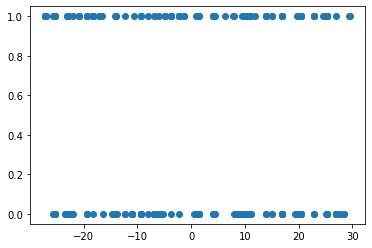

In [256]:
plt.scatter(x_train , y_train)

- ***Reducing all features to 2 dimensions***

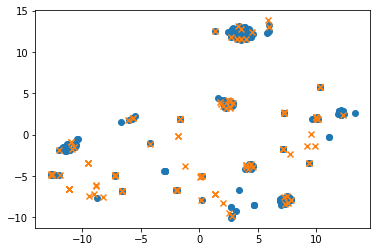

In [260]:
from sklearn.manifold import TSNE 
tsne2 = TSNE(n_components=2)
x_train = tsne2.fit_transform(X_train)

y_tr = y_train.values.flatten()
x_0 = x_train[y_tr == 0]
x_1 = x_train[y_tr == 1]


plt.scatter(x_0[:, 0], x_0[:, 1])
plt.scatter(x_1[:, 0], x_1[:, 1], marker='x')